In [1]:
import os
import gzip

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Bio import SeqIO

from IPython.display import display

%matplotlib inline

DIR = r'c://downloads'

plt.style.use('ggplot')

Pearson's correlation: r = 0.07, p-value = 3.8e-06
Spearman's correlation: rho = 0.07, p-value = 4.3e-06
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     21.42
Date:                Mon, 06 Jan 2020   Prob (F-statistic):           3.79e-06
Time:                        18:03:20   Log-Likelihood:                 13459.
No. Observations:                4852   AIC:                        -2.691e+04
Df Residuals:                    4850   BIC:                        -2.690e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

(0, 0.2)

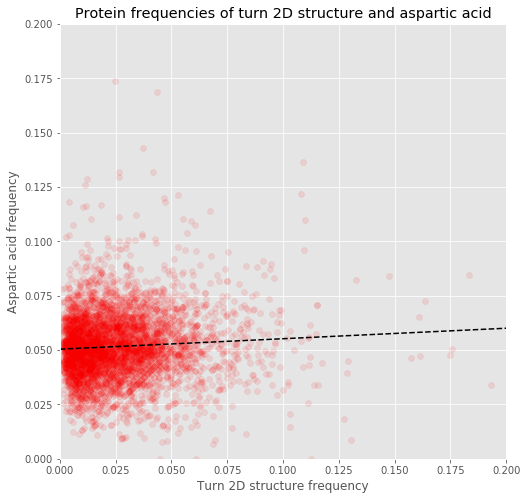

In [2]:
from scipy.stats import pearsonr, spearmanr
from statsmodels import api as sm

turn_freqs = []
D_freqs = []

# From: http://www.uniprot.org/uniprot/?query=reviewed%3Ayes+AND+organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22&sort=score
with gzip.open(os.path.join(DIR, 'uniprot_human_reviewed.xml.gz'), 'rt') as f:
    for record in SeqIO.parse(f, 'uniprot-xml'):
        
        protein_length = len(record.seq)
        turn_length = sum([feature.location.end - feature.location.start for feature in record.features if \
                feature.type == 'turn'])
                
        if turn_length > 0:
            turn_freqs.append(turn_length / protein_length)
            D_freqs.append(record.seq.count('D') / protein_length)
        
print('Pearson\'s correlation: r = %.2f, p-value = %.2g' % pearsonr(turn_freqs, D_freqs))
print('Spearman\'s correlation: rho = %.2f, p-value = %.2g' % spearmanr(turn_freqs, D_freqs))

regression_model = sm.OLS(D_freqs, sm.add_constant(turn_freqs))
regression_results = regression_model.fit()
print(regression_results.summary())

regression_x = np.array([0, 0.2])
regression_y = regression_results.predict(sm.add_constant(regression_x))

fig, ax = plt.subplots(figsize = (8, 8))
ax.plot(regression_x, regression_y, '--', color = 'black')
ax.scatter(turn_freqs, D_freqs, color = 'red', alpha = 0.1)
ax.set_title('Protein frequencies of turn 2D structure and aspartic acid')
ax.set_xlabel('Turn 2D structure frequency')
ax.set_ylabel('Aspartic acid frequency')
ax.set_xlim((0, 0.2))
ax.set_ylim((0, 0.2))

The correlation appears very significant, but weak. Pearson's and Spearman's produce pretty much the same results.

In transmembrane proteins, 26.7% of the residues are hydrophobic; in other proteins, 21.4% are hydrophobic.
average ratio = 1.25, p-value: 0


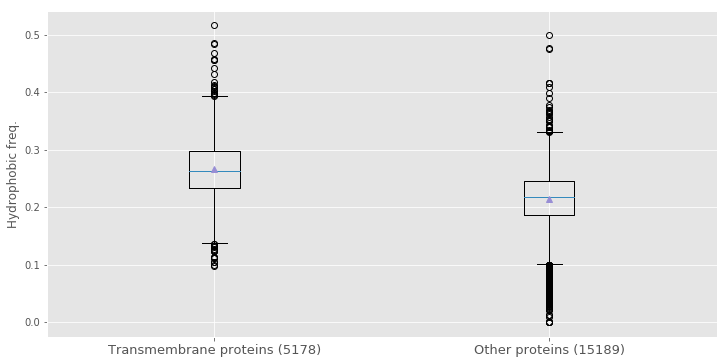

In [3]:
from scipy.stats import ttest_ind

transmembrane_hdryophobic_freqs = []
non_transmembrane_hdryophobic_freqs = []

HYDROPHOBIC_AAS = {'I', 'L', 'V', 'M'}

def count_hydrophobic_residues(aa_seq):
    
    hydrophobic_residues = 0
    
    for aa in aa_seq:
        if aa in HYDROPHOBIC_AAS:
            hydrophobic_residues += 1
    
    return hydrophobic_residues

with gzip.open(os.path.join(DIR, 'uniprot_human_reviewed.xml.gz'), 'rt') as f:
    for record in SeqIO.parse(f, 'uniprot-xml'):
        
        hdryophobic_freq = count_hydrophobic_residues(str(record.seq)) / len(record.seq)
        
        if 'Transmembrane' in record.annotations['keywords']:
            transmembrane_hdryophobic_freqs.append(hdryophobic_freq)
        else:
            non_transmembrane_hdryophobic_freqs.append(hdryophobic_freq)
            
fig, ax = plt.subplots(figsize = (12, 6))
ax.boxplot([transmembrane_hdryophobic_freqs, non_transmembrane_hdryophobic_freqs], showmeans = True)
ax.set_xticklabels(['Transmembrane proteins (%d)' % len(transmembrane_hdryophobic_freqs), \
        'Other proteins (%d)' % len(non_transmembrane_hdryophobic_freqs)], fontsize = 13)
ax.set_ylabel('Hydrophobic freq.')
            
transmembrane_hdryophobic_freq_avg = np.average(transmembrane_hdryophobic_freqs)
non_transmembrane_hdryophobic_freq_avg = np.average(non_transmembrane_hdryophobic_freqs)
avg_ratio = transmembrane_hdryophobic_freq_avg / non_transmembrane_hdryophobic_freq_avg
_, pval = ttest_ind(transmembrane_hdryophobic_freqs, non_transmembrane_hdryophobic_freqs, equal_var = False)

print('In transmembrane proteins, %.1f%% of the residues are hydrophobic; in other proteins, %.1f%% are hydrophobic.' % \
        (100 * transmembrane_hdryophobic_freq_avg, 100 * non_transmembrane_hdryophobic_freq_avg))
print('average ratio = %.2f, p-value: %.2g' % (avg_ratio, pval))

The association is extremely significant, and also quite strong.